In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [13]:
image_folder = "C:/Users/user/Desktop/archive/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone" 
csv_file = "C:/Users/user/Desktop/archive/fichier_corrige.csv"

In [14]:
IMG_SIZE = (128, 128)
EPOCHS = 20
BATCH_SIZE = 32

In [15]:
df = pd.read_csv(csv_file)

In [16]:
import os 
X = []
y = []

for index, row in df.iterrows():
    img_path = row['path']
    if os.path.exists(img_path):
        img = load_img(img_path, target_size=IMG_SIZE)
        img_array = img_to_array(img) / 255.0
        X.append(img_array)
        y.append(row['Class'])

X = np.array(X)
y = np.array(y)

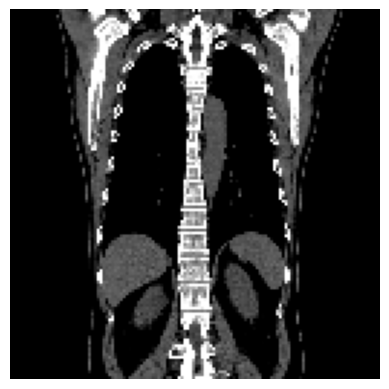

In [17]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Charger la première image
img_path = df['path'].iloc[12001]  # Prendre le chemin de la première image
img = load_img(img_path, target_size=IMG_SIZE)  # Charger l'image avec la taille spécifiée
img_array = img_to_array(img) / 255.0  # Normaliser l'image entre 0 et 1

# Afficher l'image
plt.imshow(img_array)
plt.axis('off')  # Masquer les axes
plt.show()


In [18]:
# === 1. Encodage des labels ===
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_encoded_cat = to_categorical(y_encoded)


In [19]:

X_train, X_val, y_train, y_val = train_test_split(X, y_encoded_cat, test_size=0.2, random_state=42)

In [20]:
# === 2. Définir l’autoencodeur ===
import tensorflow as tf
input_layer = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

from tensorflow.keras.models import Model
from tensorflow.keras.layers import UpSampling2D, Reshape

# === Encodeur ===
input_img = Input(shape=(128, 128, 3))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
latent = Dense(64, activation='relu', name="latent_vector")(x)

# === Décodeur ===
x = Dense(16 * 16 * 128, activation='relu')(latent)
x = Reshape((16, 16, 128))(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)



In [21]:
# Modèle autoencodeur
autoencoder = Model(inputs=input_img, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
autoencoder.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_vector (Dense)           │ (None, 64)             │     2,097,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32768)          │     2,129,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,413,891 (16.84 MB)

 Trainable params: 4,413,699 (16.84 MB)

 Non-trainable params: 192 (768.00 B)

In [22]:
history_auto = autoencoder.fit(X_train, X_train,
                               epochs=20,
                               batch_size=32,
                               validation_data=(X_val, X_val),
                               callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])


Epoch 1/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 160s 504ms/step - loss: 0.0341 - val_loss: 0.0330
Epoch 2/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 161s 517ms/step - loss: 0.0170 - val_loss: 0.0145
Epoch 3/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 167s 534ms/step - loss: 0.0139 - val_loss: 0.0125
Epoch 4/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 168s 537ms/step - loss: 0.0121 - val_loss: 0.0115
Epoch 5/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 171s 550ms/step - loss: 0.0108 - val_loss: 0.0108
Epoch 6/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 172s 552ms/step - loss: 0.0101 - val_loss: 0.0096
Epoch 7/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 171s 549ms/step - loss: 0.0094 - val_loss: 0.0092
Epoch 8/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 171s 550ms/step - loss: 0.0090 - val_loss: 0.0089
Epoch 9/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 171s 547ms/step - loss: 0.0086 - val_loss: 0.0087
Epoch 10/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 279s 894ms/step - loss: 0.0083 - val_loss: 0.0083
Epoch 11/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 193s 620ms/step - loss: 0.0081 - val_loss: 0.0081
Epoch 12

In [23]:
encoder = Model(inputs=input_img, outputs=autoencoder.get_layer("latent_vector").output)
X_train_latent = encoder.predict(X_train)
X_val_latent = encoder.predict(X_val)


312/312 ━━━━━━━━━━━━━━━━━━━━ 22s 70ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step


In [24]:
classifier = Sequential([
    Dense(128, activation='relu', input_shape=(64,)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_encoded_cat.shape[1], activation='softmax')
])

c:\Users\user\Desktop\PI\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
classifier.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
history_ann = classifier.fit(X_train_latent, y_train, epochs=20, batch_size=32,
                             validation_data=(X_val_latent, y_val),
                             callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4760 - loss: 1.4763 - val_accuracy: 0.8843 - val_loss: 0.3884
Epoch 2/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7638 - loss: 0.6154 - val_accuracy: 0.9390 - val_loss: 0.2240
Epoch 3/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8329 - loss: 0.4267 - val_accuracy: 0.9659 - val_loss: 0.1416
Epoch 4/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8798 - loss: 0.3186 - val_accuracy: 0.9843 - val_loss: 0.0950
Epoch 5/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8997 - loss: 0.2632 - val_accuracy: 0.9859 - val_loss: 0.0646
Epoch 6/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9300 - loss: 0.1989 - val_accuracy: 0.9896 - val_loss: 0.0484
Epoch 7/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9428 - loss: 0.1649 - val_accuracy: 0.9912 - val_loss: 0.0345
Epoch 8/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9512 - loss: 0.1396 - val_accuracy: 0.

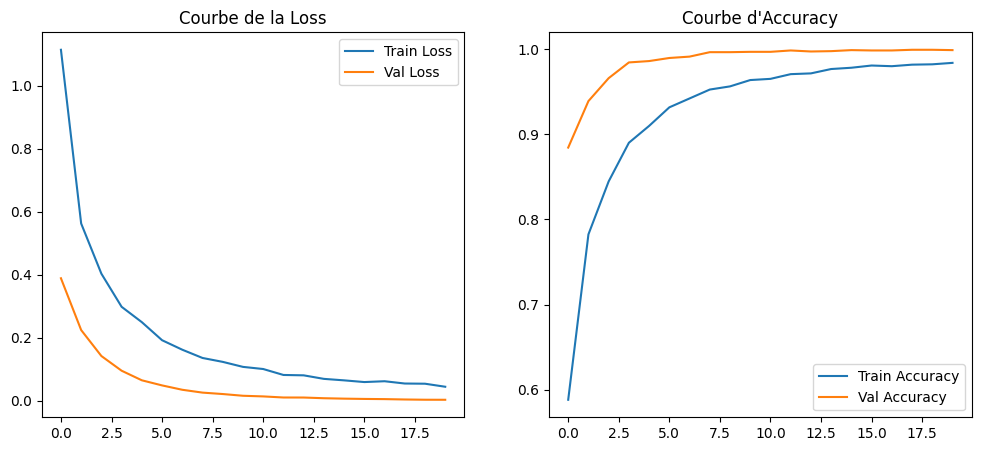

In [27]:
import matplotlib.pyplot as plt

# Courbes de loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_ann.history['loss'], label='Train Loss')
plt.plot(history_ann.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Courbe de la Loss')

plt.subplot(1, 2, 2)
plt.plot(history_ann.history['accuracy'], label='Train Accuracy')
plt.plot(history_ann.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Courbe d'Accuracy")
plt.show()



78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


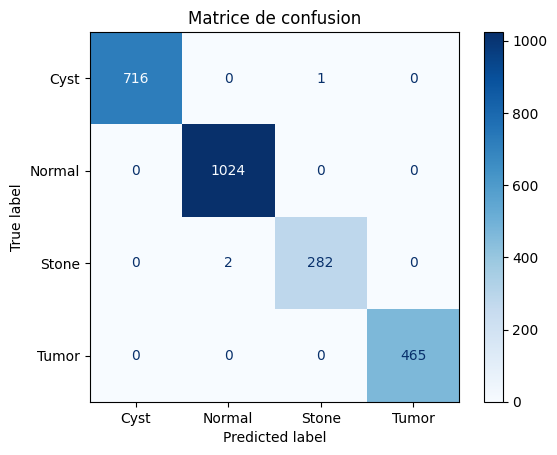

In [28]:
y_val_pred_probs = classifier.predict(X_val_latent)
y_val_preds = np.argmax(y_val_pred_probs, axis=1)
y_val_true = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_val_true, y_val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.title("Matrice de confusion")
plt.show()


In [30]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
report = classification_report(y_val_true, y_val_preds, target_names=le.classes_)
print(report)

              precision    recall  f1-score   support

        Cyst       1.00      1.00      1.00       717
      Normal       1.00      1.00      1.00      1024
       Stone       1.00      0.99      0.99       284
       Tumor       1.00      1.00      1.00       465

    accuracy                           1.00      2490
   macro avg       1.00      1.00      1.00      2490
weighted avg       1.00      1.00      1.00      2490



In [38]:
# 7. Fonction de prédiction
def predict_image_class(img_path, encoder_model, classifier_model, label_encoder):
    img = load_img(img_path, target_size=IMG_SIZE)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Image testée")
    plt.show()
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    latent = encoder_model.predict(img_array)
    pred = classifier_model.predict(latent)
    class_index = np.argmax(pred)
    return label_encoder.inverse_transform([class_index])[0]

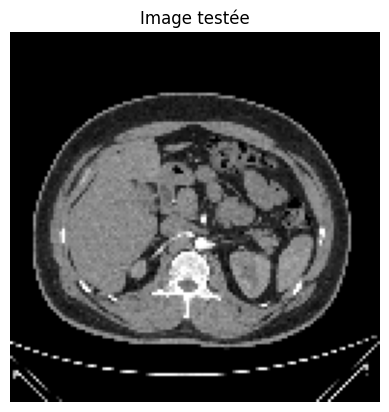

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


np.str_('Normal')

In [40]:
predict_image_class(r"C:\Users\user\Desktop\archive\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\Normal\Normal- (14).jpg", encoder, classifier, le)

In [41]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

c:\Users\user\Desktop\PI\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Fonction que LIME 
def predict_fn(images):
    images = np.array(images) 
    latent = encoder.predict(images)
    preds = classifier.predict(latent)
    return preds


In [43]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# === Charger une image ===
image_path = r"C:\Users\user\Desktop\archive\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\Tumor\Tumor- (154).jpg"
img = load_img(image_path, target_size=IMG_SIZE)
img_array = img_to_array(img).astype('double')  # Doit être float64 pour LIME
img_array = np.array(img_array)

# === Créer l'explainer LIME ===
explainer = lime_image.LimeImageExplainer()

# === Générer l'explication ===
explanation = explainer.explain_instance(
    image=img_array,
    classifier_fn=predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  1%|          | 10/1000 [00:00<00:30, 32.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  2%|▏         | 20/1000 [00:00<00:28, 34.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  3%|▎         | 30/1000 [00:00<00:23, 41.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  4%|▍         | 40/1000 [00:01<00:23, 41.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  5%|▌         | 50/1000 [00:01<00:21, 44.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


  6%|▌         | 60/1000 [00:01<00:24, 38.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  7%|▋         | 70/1000 [00:01<00:23, 40.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  8%|▊         | 80/1000 [00:01<00:22, 41.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  9%|▉         | 90/1000 [00:02<00:21, 42.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 10%|█         | 100/1000 [00:02<00:21, 41.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 11%|█         | 110/1000 [00:02<00:21, 42.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 12%|█▏        | 120/1000 [00:02<00:19, 45.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 13%|█▎        | 130/1000 [00:03<00:18, 46.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 14%|█▍        | 140/1000 [00:03<00:18, 46.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 15%|█▌        | 150/1000 [00:03<00:16, 50.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 16%|█▌        | 160/1000 [00:03<00:16, 50.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 17%|█▋        | 170/1000 [00:03<00:16, 51.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 18%|█▊        | 180/1000 [00:04<00:15, 51.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 19%|█▉        | 190/1000 [00:04<00:16, 48.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 20%|██        | 200/1000 [00:04<00:17, 46.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 21%|██        | 210/1000 [00:04<00:16, 48.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 22%|██▏       | 220/1000 [00:04<00:15, 49.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 23%|██▎       | 230/1000 [00:05<00:15, 50.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 24%|██▍       | 240/1000 [00:05<00:14, 52.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 25%|██▌       | 250/1000 [00:05<00:13, 55.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 26%|██▌       | 260/1000 [00:05<00:13, 54.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 27%|██▋       | 270/1000 [00:05<00:14, 50.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 28%|██▊       | 280/1000 [00:05<00:13, 53.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 29%|██▉       | 290/1000 [00:06<00:13, 54.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 30%|███       | 300/1000 [00:06<00:13, 51.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 31%|███       | 310/1000 [00:06<00:14, 46.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 32%|███▏      | 320/1000 [00:06<00:15, 43.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 33%|███▎      | 330/1000 [00:07<00:16, 41.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 34%|███▍      | 340/1000 [00:07<00:14, 45.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 35%|███▌      | 350/1000 [00:07<00:13, 48.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 36%|███▌      | 360/1000 [00:07<00:12, 51.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 37%|███▋      | 370/1000 [00:07<00:11, 54.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 38%|███▊      | 380/1000 [00:07<00:10, 56.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 39%|███▉      | 390/1000 [00:08<00:10, 58.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 40%|████      | 400/1000 [00:08<00:09, 61.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 41%|████      | 410/1000 [00:08<00:10, 57.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 42%|████▏     | 420/1000 [00:08<00:11, 52.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 43%|████▎     | 430/1000 [00:08<00:10, 54.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 44%|████▍     | 440/1000 [00:09<00:10, 55.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 45%|████▌     | 450/1000 [00:09<00:09, 58.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 46%|████▌     | 460/1000 [00:09<00:09, 58.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 47%|████▋     | 470/1000 [00:09<00:09, 57.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 48%|████▊     | 480/1000 [00:09<00:09, 56.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 49%|████▉     | 490/1000 [00:09<00:08, 56.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 50%|█████     | 500/1000 [00:10<00:08, 58.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 51%|█████     | 510/1000 [00:10<00:09, 49.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 52%|█████▏    | 520/1000 [00:10<00:09, 49.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 53%|█████▎    | 530/1000 [00:10<00:09, 50.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▍    | 540/1000 [00:10<00:09, 50.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 55%|█████▌    | 550/1000 [00:11<00:08, 51.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 56%|█████▌    | 560/1000 [00:11<00:08, 51.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 57%|█████▋    | 570/1000 [00:11<00:09, 46.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 58%|█████▊    | 580/1000 [00:11<00:08, 47.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 59%|█████▉    | 590/1000 [00:12<00:08, 46.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 60%|██████    | 600/1000 [00:12<00:08, 48.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 61%|██████    | 610/1000 [00:12<00:09, 41.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 62%|██████▏   | 620/1000 [00:12<00:08, 43.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 63%|██████▎   | 630/1000 [00:12<00:07, 46.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 64%|██████▍   | 640/1000 [00:13<00:07, 50.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 65%|██████▌   | 650/1000 [00:13<00:06, 50.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 66%|██████▌   | 660/1000 [00:13<00:07, 46.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 67%|██████▋   | 670/1000 [00:13<00:07, 44.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 68%|██████▊   | 680/1000 [00:13<00:07, 43.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 69%|██████▉   | 690/1000 [00:14<00:07, 39.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 70%|███████   | 700/1000 [00:14<00:07, 40.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 71%|███████   | 710/1000 [00:14<00:06, 42.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 72%|███████▏  | 720/1000 [00:14<00:06, 44.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 73%|███████▎  | 730/1000 [00:15<00:05, 45.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 74%|███████▍  | 740/1000 [00:15<00:05, 45.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 75%|███████▌  | 750/1000 [00:15<00:05, 45.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 76%|███████▌  | 760/1000 [00:15<00:05, 42.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 77%|███████▋  | 770/1000 [00:16<00:05, 41.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 78%|███████▊  | 780/1000 [00:16<00:05, 38.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 79%|███████▉  | 790/1000 [00:16<00:05, 40.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 80%|████████  | 800/1000 [00:16<00:04, 42.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 81%|████████  | 810/1000 [00:17<00:04, 45.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 82%|████████▏ | 820/1000 [00:17<00:03, 47.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 83%|████████▎ | 830/1000 [00:17<00:03, 50.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 84%|████████▍ | 840/1000 [00:17<00:03, 52.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 85%|████████▌ | 850/1000 [00:17<00:02, 53.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 86%|████████▌ | 860/1000 [00:17<00:02, 51.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 87%|████████▋ | 870/1000 [00:18<00:02, 52.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 88%|████████▊ | 880/1000 [00:18<00:02, 52.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 89%|████████▉ | 890/1000 [00:18<00:02, 51.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 90%|█████████ | 900/1000 [00:18<00:01, 53.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 91%|█████████ | 910/1000 [00:18<00:01, 52.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 92%|█████████▏| 920/1000 [00:19<00:01, 52.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 93%|█████████▎| 930/1000 [00:19<00:01, 50.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 940/1000 [00:19<00:01, 49.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 95%|█████████▌| 950/1000 [00:19<00:01, 39.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 96%|█████████▌| 960/1000 [00:20<00:01, 35.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 97%|█████████▋| 970/1000 [00:20<00:00, 38.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 98%|█████████▊| 980/1000 [00:20<00:00, 40.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 99%|█████████▉| 990/1000 [00:20<00:00, 44.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


100%|██████████| 1000/1000 [00:21<00:00, 47.51it/s]


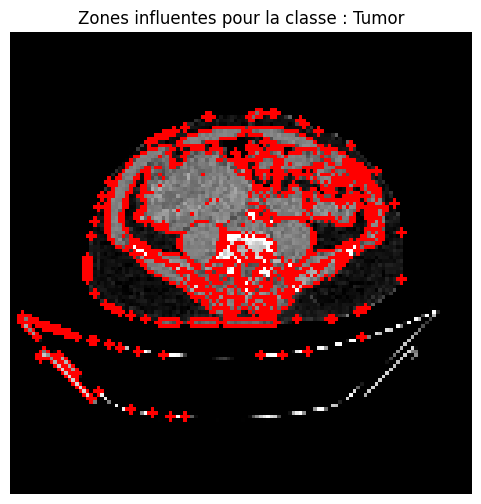

In [45]:
from matplotlib import pyplot as plt
from skimage.segmentation import mark_boundaries

# Récupérer l'explication visuelle avec contours rouges
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],       # Index de la classe prédite
    positive_only=True,
    num_features=5,
    hide_rest=False
)

# Afficher l’image avec les zones explicatives en rouge
plt.figure(figsize=(6, 6))
plt.imshow(mark_boundaries(temp / 255.0, mask, color=(1, 0, 0)))  # Rouge
plt.title(f"Zones influentes pour la classe : {le.inverse_transform([explanation.top_labels[0]])[0]}")
plt.axis('off')
plt.show()


In [46]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def predict_and_explain(img_path, encoder_model, classifier_model, label_encoder):
    IMG_SIZE = (128, 128)

    # Charger et prétraiter l'image
    img = load_img(img_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0
    img_array_expanded = np.expand_dims(img_array, axis=0)

    # Prédiction
    latent = encoder_model.predict(img_array_expanded)
    pred = classifier_model.predict(latent)
    class_index = np.argmax(pred)
    class_name = label_encoder.inverse_transform([class_index])[0]

    # Affichage image originale
    plt.figure(figsize=(6, 6))
    plt.imshow(img_array)
    plt.title(f"Image testée - Prédiction : {class_name}")
    plt.axis('off')
    plt.show()

    # === LIME ===
    def lime_predict_fn(images):
        images = np.array(images) / 255.0
        latent = encoder_model.predict(images)
        preds = classifier_model.predict(latent)
        return preds

    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        image=(img_array * 255).astype('double'),  # LIME attend une image float64 non normalisée
        classifier_fn=lime_predict_fn,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )

    temp, mask = explanation.get_image_and_mask(
        label=explanation.top_labels[0],
        positive_only=True,
        num_features=5,
        hide_rest=False
    )

    # Affichage image avec zones explicatives en rouge
    plt.figure(figsize=(6, 6))
    plt.imshow(mark_boundaries(temp / 255.0, mask, color=(1, 0, 0)))
    plt.title(f"Zones influentes - Prédiction : {class_name}")
    plt.axis('off')
    plt.show()

    return class_name


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


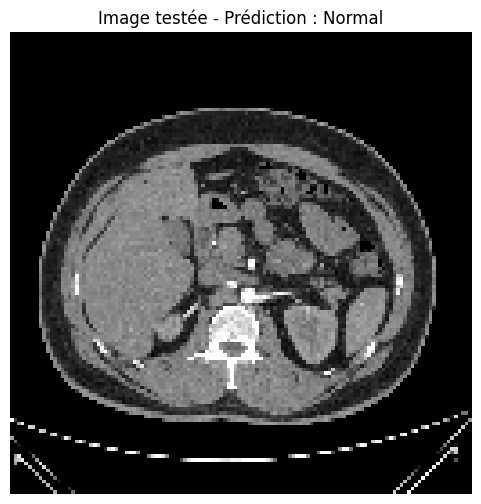

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  1%|          | 10/1000 [00:00<00:24, 39.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  2%|▏         | 20/1000 [00:00<00:20, 47.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  3%|▎         | 30/1000 [00:00<00:20, 47.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  4%|▍         | 40/1000 [00:00<00:23, 41.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  5%|▌         | 50/1000 [00:01<00:20, 46.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  6%|▌         | 60/1000 [00:01<00:19, 49.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  7%|▋         | 70/1000 [00:01<00:17, 51.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  8%|▊         | 80/1000 [00:01<00:17, 53.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  9%|▉         | 90/1000 [00:01<00:19, 46.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 10%|█         | 100/1000 [00:02<00:19, 47.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 11%|█         | 110/1000 [00:02<00:19, 46.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 12%|█▏        | 120/1000 [00:02<00:19, 45.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 13%|█▎        | 130/1000 [00:02<00:18, 46.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 14%|█▍        | 140/1000 [00:03<00:18, 45.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 15%|█▌        | 150/1000 [00:03<00:18, 44.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 16%|█▌        | 160/1000 [00:03<00:18, 45.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 17%|█▋        | 170/1000 [00:03<00:17, 46.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 18%|█▊        | 180/1000 [00:03<00:17, 46.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 19%|█▉        | 190/1000 [00:04<00:17, 47.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 20%|██        | 200/1000 [00:04<00:16, 49.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 21%|██        | 210/1000 [00:04<00:15, 50.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 22%|██▏       | 220/1000 [00:04<00:16, 47.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 23%|██▎       | 230/1000 [00:04<00:16, 45.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 24%|██▍       | 240/1000 [00:05<00:16, 46.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 25%|██▌       | 250/1000 [00:05<00:16, 45.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 26%|██▌       | 260/1000 [00:05<00:15, 47.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 27%|██▋       | 270/1000 [00:05<00:15, 48.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 28%|██▊       | 280/1000 [00:05<00:14, 50.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 29%|██▉       | 290/1000 [00:06<00:14, 49.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 30%|███       | 300/1000 [00:06<00:14, 47.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 31%|███       | 310/1000 [00:06<00:16, 41.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 32%|███▏      | 320/1000 [00:06<00:17, 38.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 33%|███▎      | 330/1000 [00:07<00:17, 37.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 34%|███▍      | 340/1000 [00:07<00:16, 39.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 35%|███▌      | 350/1000 [00:07<00:15, 42.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 36%|███▌      | 360/1000 [00:07<00:15, 40.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 37%|███▋      | 370/1000 [00:08<00:17, 36.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 38%|███▊      | 380/1000 [00:08<00:17, 35.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 39%|███▉      | 390/1000 [00:08<00:18, 33.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 40%|████      | 400/1000 [00:09<00:17, 34.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 41%|████      | 410/1000 [00:09<00:17, 33.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 42%|████▏     | 420/1000 [00:09<00:16, 36.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 43%|████▎     | 430/1000 [00:10<00:17, 33.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 44%|████▍     | 440/1000 [00:10<00:16, 33.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 45%|████▌     | 450/1000 [00:10<00:15, 35.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 46%|████▌     | 460/1000 [00:10<00:15, 34.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 47%|████▋     | 470/1000 [00:11<00:13, 38.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 48%|████▊     | 480/1000 [00:11<00:12, 42.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 49%|████▉     | 490/1000 [00:11<00:12, 42.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 50%|█████     | 500/1000 [00:11<00:12, 39.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 51%|█████     | 510/1000 [00:12<00:13, 36.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 52%|█████▏    | 520/1000 [00:12<00:12, 39.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 53%|█████▎    | 530/1000 [00:12<00:11, 41.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 54%|█████▍    | 540/1000 [00:12<00:10, 44.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 55%|█████▌    | 550/1000 [00:12<00:09, 47.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 56%|█████▌    | 560/1000 [00:13<00:08, 49.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 57%|█████▋    | 570/1000 [00:13<00:09, 47.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 58%|█████▊    | 580/1000 [00:13<00:08, 46.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 59%|█████▉    | 590/1000 [00:13<00:09, 45.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 60%|██████    | 600/1000 [00:14<00:09, 41.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 61%|██████    | 610/1000 [00:14<00:10, 38.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 62%|██████▏   | 620/1000 [00:14<00:09, 40.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 63%|██████▎   | 630/1000 [00:14<00:08, 42.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 64%|██████▍   | 640/1000 [00:15<00:07, 45.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 65%|██████▌   | 650/1000 [00:15<00:07, 46.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 66%|██████▌   | 660/1000 [00:15<00:06, 49.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 67%|██████▋   | 670/1000 [00:15<00:07, 44.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 68%|██████▊   | 680/1000 [00:15<00:07, 44.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 69%|██████▉   | 690/1000 [00:16<00:06, 46.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 70%|███████   | 700/1000 [00:16<00:06, 48.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 71%|███████   | 710/1000 [00:16<00:05, 50.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 72%|███████▏  | 720/1000 [00:16<00:05, 50.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 73%|███████▎  | 730/1000 [00:16<00:05, 50.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 74%|███████▍  | 740/1000 [00:17<00:05, 51.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 75%|███████▌  | 750/1000 [00:17<00:04, 50.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 76%|███████▌  | 760/1000 [00:17<00:04, 49.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 77%|███████▋  | 770/1000 [00:17<00:04, 49.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 78%|███████▊  | 780/1000 [00:17<00:04, 48.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 79%|███████▉  | 790/1000 [00:18<00:04, 49.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 80%|████████  | 800/1000 [00:18<00:04, 49.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 81%|████████  | 810/1000 [00:18<00:04, 46.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 82%|████████▏ | 820/1000 [00:18<00:03, 45.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 83%|████████▎ | 830/1000 [00:18<00:03, 46.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 84%|████████▍ | 840/1000 [00:19<00:03, 42.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 85%|████████▌ | 850/1000 [00:19<00:03, 39.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 86%|████████▌ | 860/1000 [00:19<00:03, 41.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 87%|████████▋ | 870/1000 [00:20<00:03, 36.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 88%|████████▊ | 880/1000 [00:20<00:03, 37.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 89%|████████▉ | 890/1000 [00:20<00:02, 39.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 90%|█████████ | 900/1000 [00:20<00:02, 41.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 91%|█████████ | 910/1000 [00:20<00:02, 43.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 92%|█████████▏| 920/1000 [00:21<00:01, 42.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 93%|█████████▎| 930/1000 [00:21<00:01, 44.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 94%|█████████▍| 940/1000 [00:21<00:01, 42.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 95%|█████████▌| 950/1000 [00:21<00:01, 41.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 96%|█████████▌| 960/1000 [00:22<00:00, 41.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 97%|█████████▋| 970/1000 [00:22<00:00, 41.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 98%|█████████▊| 980/1000 [00:22<00:00, 44.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 99%|█████████▉| 990/1000 [00:22<00:00, 45.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


100%|██████████| 1000/1000 [00:23<00:00, 43.39it/s]


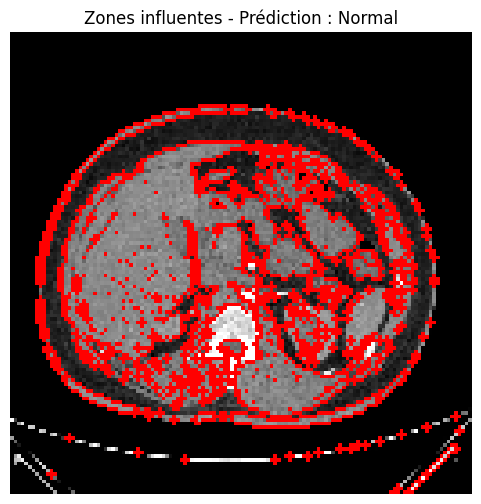

np.str_('Normal')

In [48]:
predict_and_explain(
    r"C:\Users\user\Desktop\archive\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\Normal\Normal- (16).jpg",
    encoder,
    classifier,
    le
)
